# ML - assignment_3

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import shap
import math

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", palette="pastel")

import warnings
warnings.filterwarnings('ignore')

import os
from joblib import dump, load

c:\dev\santander\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA (Exploratory Data Analysis)

In [2]:
# reading the data into a DataFrame
df = pd.read_csv(r'data/train.csv', index_col=0)

In [3]:
# inspecitng the head of the dataframe
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
# inspecting info of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, train_0 to train_199999
Columns: 201 entries, target to var_199
dtypes: float64(200), int64(1)
memory usage: 308.2+ MB


In [5]:
# zooming in on missing values
df.isnull().sum()

target     0
var_0      0
var_1      0
var_2      0
var_3      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 201, dtype: int64

In [6]:
# inspecting the df statistics
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [7]:
# getting all var_x columns
features_to_plot = [col for col in df.columns if 'var' in col]
# defining 5 plots per row
plots_per_row = 5
# extracting the number of plots by the length of columns
number_of_plots = len(features_to_plot)
# calculating the amount of rows needed (rounded up)
number_of_rows = math.ceil(number_of_plots / plots_per_row)

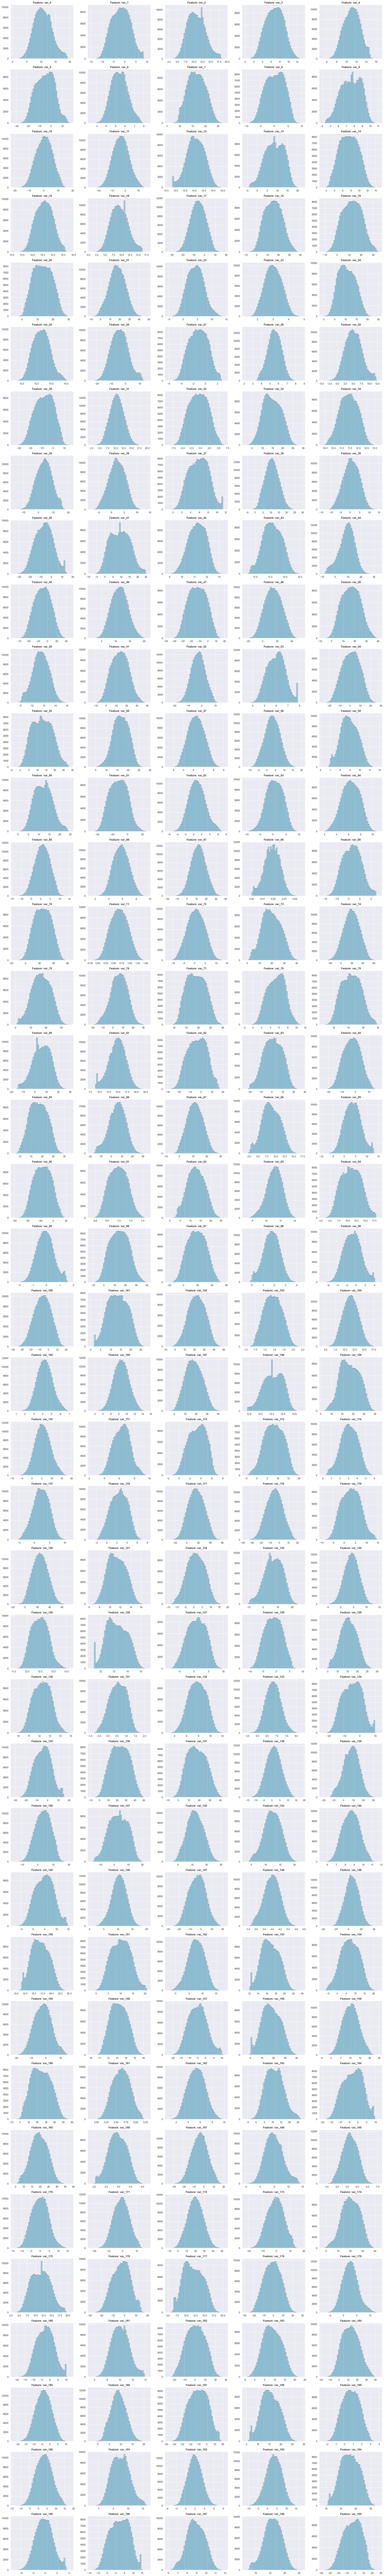

In [8]:
# defining the figure canvas
plt.figure(figsize=(24, number_of_rows * 4)) 
# creating a loop to go over all columns, each col is getting a subplot
for i, col in enumerate(features_to_plot):
    plt.subplot(number_of_rows, plots_per_row, i + 1)
    
    # Using bins=50 for performance on large datasets
    sns.histplot(df[col], bins=50, kde=False, color='skyblue', edgecolor='black', linewidth=0.5)
    
    plt.title(col, fontsize=10, fontweight='bold')
    plt.xlabel('') # Hiding x-label to save space
    plt.ylabel('') # Hiding y-label to clean up noise
    
    plt.title(f"Feature: {col}", fontsize=12, fontweight='bold', color='#333333')

plt.tight_layout()
plt.show()

In [9]:
#cheking the min and max for all of the features in the dataset
features = [col for col in df.columns if 'var' in col]
summary_df = df[features].agg(['min', 'max']).transpose()
summary_df['range'] = summary_df['max'] - summary_df['min']
summary_df = summary_df.sort_values(by='range', ascending=False)

print("--- Variables with the Largest Range ---")
print(summary_df.head(10))

print("\n--- Variables with the Smallest Range ---")
print(summary_df.tail(10))

--- Variables with the Largest Range ---
             min      max     range
var_45  -90.2525  62.0844  152.3369
var_74  -34.1015  70.2720  104.3735
var_117 -31.8369  64.8109   96.6478
var_120 -18.6962  74.0321   92.7283
var_149 -41.1683  48.4240   89.5923
var_90  -61.7180  27.2713   88.9893
var_70  -17.0275  64.4644   81.4919
var_97  -21.7400  58.2879   80.0279
var_48  -23.9022  54.2738   78.1760
var_61  -48.8027  27.1029   75.9056

--- Variables with the Smallest Range ---
             min      max   range
var_25   12.7200  14.6546  1.9346
var_43   10.6528  12.5779  1.9251
var_71   -0.2240   1.5719  1.7959
var_161   4.8526   6.3099  1.4573
var_148   3.3205   4.7528  1.4323
var_12   13.4346  14.6545  1.2199
var_103   0.9793   2.1887  1.2094
var_108  13.7290  14.7430  1.0140
var_91    6.5218   7.4895  0.9677
var_68    4.9938   5.0469  0.0531


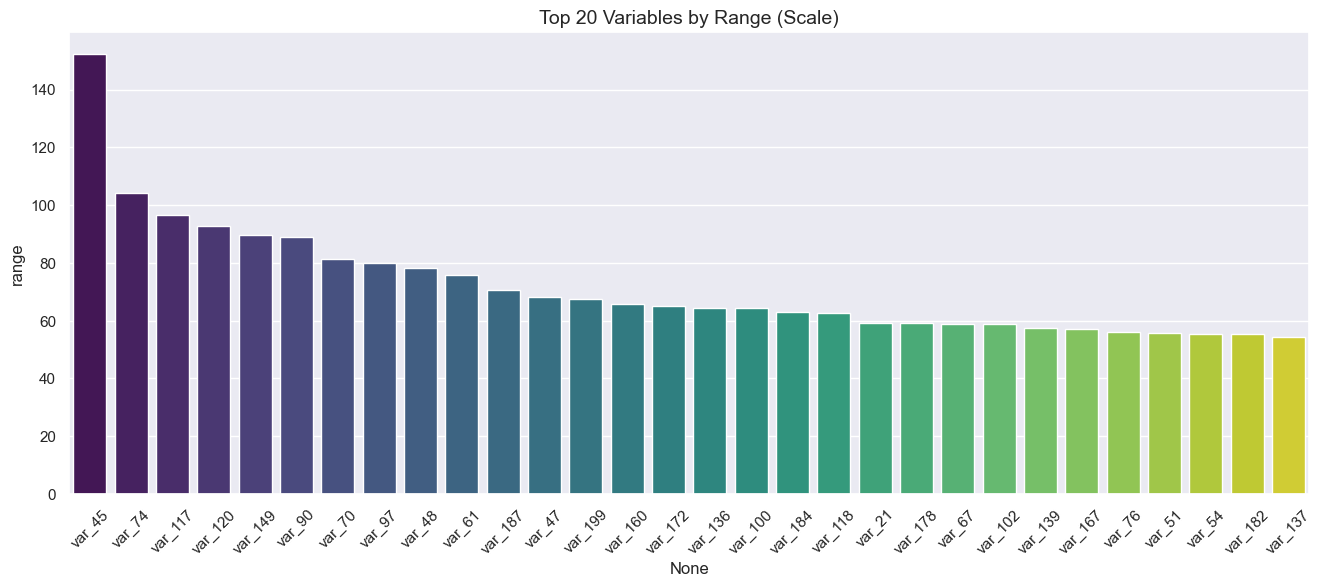

In [10]:
#visualizing top 30 features range descending 
plt.figure(figsize=(16, 6))
sns.barplot(x=summary_df.index[:30], y=summary_df['range'][:30], palette='viridis')
plt.title("Top 20 Variables by Range (Scale)", fontsize=14)
plt.xticks(rotation=45)
plt.show()

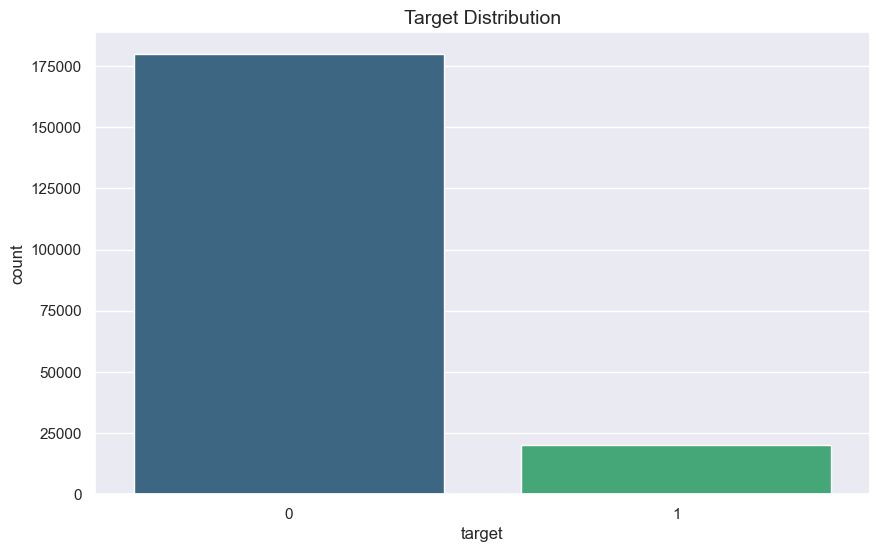

In [11]:
#visualizing the target distribution 
plt.figure(figsize=(10, 6))
sns.countplot(x=df['target'], palette='viridis')
plt.title("Target Distribution", fontsize=14)
plt.show()

In [12]:
# Checking correlation with target
feature_cols = [col for col in df.columns if 'var' in col]
correlations = df[feature_cols].corrwith(df['target']).sort_values(ascending=False)

print("--- Top 20 Features Correlated with Target ---")
print(correlations.head(20))
print("\n--- Bottom 10 Features (Negatively Correlated) ---")
print(correlations.tail(10))

--- Top 20 Features Correlated with Target ---
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
var_0      0.052390
var_1      0.050343
var_179    0.050002
var_40     0.049530
var_184    0.048315
var_78     0.048245
var_170    0.047973
var_191    0.047114
var_94     0.046296
var_67     0.044673
var_18     0.043479
dtype: float64

--- Bottom 10 Features (Negatively Correlated) ---
var_165   -0.055734
var_80    -0.057609
var_166   -0.057773
var_21    -0.058483
var_174   -0.061669
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
dtype: float64


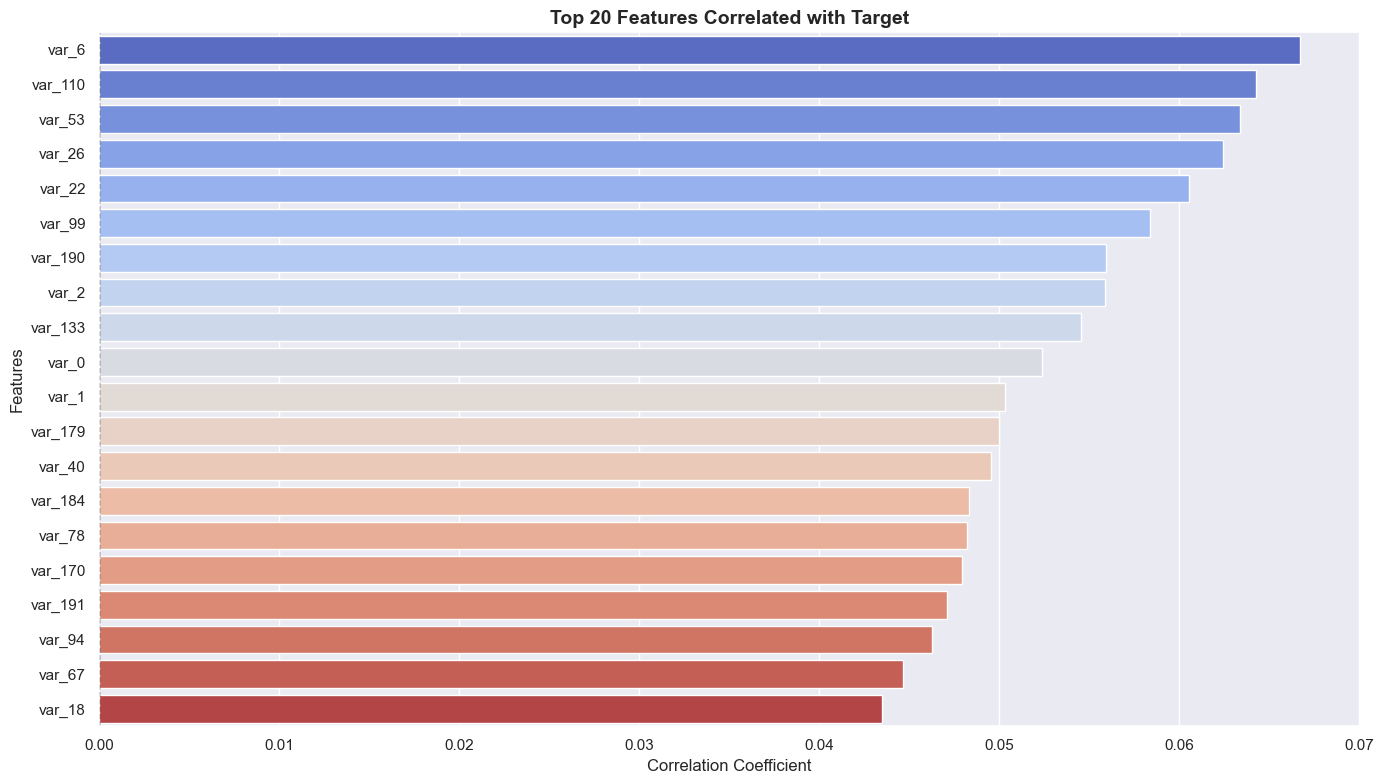

In [13]:
# Visualizing feature correlations with target
plt.figure(figsize=(14, 8))
top_corr_features = correlations.head(20)
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='coolwarm')
plt.title("Top 20 Features Correlated with Target", fontsize=14, fontweight='bold')
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

In [15]:
# Checking for outliers using IQR method
outlier_info = {}
for col in feature_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_info[col] = {'outliers': outlier_count, 'percentage': (outlier_count / len(df)) * 100}

outlier_df = pd.DataFrame(outlier_info).transpose().sort_values('outliers', ascending=False)
print("--- Top 15 Features with Most Outliers ---")
print(outlier_df.head(15))

--- Top 15 Features with Most Outliers ---
         outliers  percentage
var_179    1509.0      0.7545
var_44     1208.0      0.6040
var_93      889.0      0.4445
var_146     804.0      0.4020
var_192     733.0      0.3665
var_31      637.0      0.3185
var_133     589.0      0.2945
var_105     572.0      0.2860
var_38      502.0      0.2510
var_124     498.0      0.2490
var_110     470.0      0.2350
var_67      465.0      0.2325
var_193     461.0      0.2305
var_186     446.0      0.2230
var_62      432.0      0.2160


## Complete Modeling Pipeline

In [16]:
# Data Preparation - Train/Test/Validation Split
# Select only numeric columns
X = df.drop('target', axis=1).select_dtypes(include=[np.number])
y = df['target']

# First split: 80% train+validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 70% train, 30% validation from remaining data
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

print(f"Training Set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation Set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test Set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTotal Features: {X_train.shape[1]}")
print(f"\nClass Distribution in Training Set:")
print(y_train.value_counts())

Training Set: 112000 samples (56.0%)
Validation Set: 48000 samples (24.0%)
Test Set: 40000 samples (20.0%)

Total Features: 200

Class Distribution in Training Set:
target
0    100745
1     11255
Name: count, dtype: int64


In [17]:
# Diagnostic: Check data types and for any issues
print("Data Types in X_train:")
print(X_train.dtypes.value_counts())
print(f"\nAny non-numeric columns: {X_train.select_dtypes(exclude=[np.number]).shape[1]}")
print("\nChecking for any NaN values:")
print(f"Total NaN values: {X_train.isna().sum().sum()}")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_train columns sample: {X_train.columns[:5].tolist()}")

Data Types in X_train:
float64    200
Name: count, dtype: int64

Any non-numeric columns: 0

Checking for any NaN values:
Total NaN values: 0

X_train shape: (112000, 200)
X_train columns sample: ['var_0', 'var_1', 'var_2', 'var_3', 'var_4']


In [18]:
# Feature Scaling - StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier manipulation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Feature Scaling Completed")
print(f"Scaled Training Set Mean: {X_train_scaled.mean().mean():.6f}")
print(f"Scaled Training Set Std: {X_train_scaled.std().mean():.6f}")

Feature Scaling Completed
Scaled Training Set Mean: 0.000000
Scaled Training Set Std: 1.000004


### Hyperparameter Tuning & Model Training
Perform hyperparameter optimization using GridSearchCV for key models (Random Forest, Gradient Boosting, XGBoost), then train all classification models with optimized hyperparameters and save them to disk.

In [ ]:
# Create models directory if it doesn't exist
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created '{models_dir}' directory for saving trained models")

# HYPERPARAMETER TUNING - RandomizedSearchCV

print("=" * 80)
print("STEP 1: HYPERPARAMETER TUNING - RandomizedSearchCV")
print("=" * 80)

# Define hyperparameter grids for all models (for faster tuning on large dataset, using reduced grids)
param_grids = {
    'Decision Tree': {
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10, 20],
        'criterion': ['gini', 'entropy'],
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, 30],
        'min_samples_split': [5, 10],
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
    },
    'Ada Boost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.5, 1.0],
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
    },
}

# Dictionary to store best hyperparameters
best_params = {}

for model_name, param_grid in param_grids.items():
    print(f"\nTuning {model_name}...")
    
    if model_name == 'Decision Tree':
        base_model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'Gradient Boosting':
        base_model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'XGBoost':
        base_model = XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False)
    elif model_name == 'Ada Boost':
        base_model = AdaBoostClassifier(random_state=42)
    elif model_name == 'K-Nearest Neighbors':
        base_model = KNeighborsClassifier()
    
    # Use KFold for faster cross-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Use RandomizedSearchCV over the entire training set (faster than full grid)
    grid_search = RandomizedSearchCV(base_model, param_grid, n_iter=30, cv=kfold, scoring='f1', n_jobs=-1, verbose=0, random_state=42)
    grid_search.fit(X_train_scaled, y_train)
    
    best_params[model_name] = grid_search.best_params_
    print(f"  Best F1 Score: {grid_search.best_score_:.4f}")
    print(f"  Best Parameters: {grid_search.best_params_}")

print("\n" + "=" * 80)
print("Hyperparameter tuning completed!")
print("=" * 80)

# MODEL TRAINING WITH OPTIMIZED HYPERPARAMETERS & PERSISTENCE

print("\n" + "=" * 80)
print("STEP 2: TRAINING MODELS WITH OPTIMIZED HYPERPARAMETERS")
print("=" * 80)

# Use best params from tuning for all models
models = {
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        **best_params.get('Decision Tree', {})
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42, n_jobs=-1,
        **best_params.get('Random Forest', {})
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42,
        **best_params.get('Gradient Boosting', {})
    ),
    'XGBoost': XGBClassifier(
        random_state=42, verbosity=0, use_label_encoder=False,
        **best_params.get('XGBoost', {})
    ),
    'Ada Boost': AdaBoostClassifier(
        random_state=42,
        **best_params.get('Ada Boost', {})
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        **best_params.get('K-Nearest Neighbors', {})
    ),
}

trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...", end=" ")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # Save model to disk
    model_path = os.path.join(models_dir, f'{name.replace(" ", "_").replace("(", "").replace(")", "")}.joblib')
    dump(model, model_path)
    print(f"Done (saved to {model_path})")

print("\n" + "=" * 80)
print("All models trained and saved successfully!")
print("=" * 80)

STEP 1: HYPERPARAMETER TUNING - RandomizedSearchCV

Tuning Decision Tree...
  Best F1 Score: 0.2026
  Best Parameters: {'min_samples_split': 20, 'max_depth': 20, 'criterion': 'gini'}

Tuning Random Forest...
  Best F1 Score: 0.0016
  Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 30}

Tuning Gradient Boosting...
  Best F1 Score: 0.1915
  Best Parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}

Tuning XGBoost...
  Best F1 Score: 0.1615
  Best Parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}

Tuning Ada Boost...
  Best F1 Score: 0.0171
  Best Parameters: {'n_estimators': 100, 'learning_rate': 1.0}

Tuning K-Nearest Neighbors...
  Best F1 Score: 0.0118
  Best Parameters: {'weights': 'uniform', 'n_neighbors': 3}

Hyperparameter tuning completed!

STEP 2: TRAINING MODELS WITH OPTIMIZED HYPERPARAMETERS

Training Decision Tree... Done (saved to models\Decision_Tree.joblib)

Training Random Forest... Done (saved to models\

### Model Evaluation & Performance Metrics
Evaluate all trained models across training, validation, and test datasets. Calculate key metrics including accuracy, precision, recall, F1-score, and AUC to assess model performance comprehensively.

In [20]:
# Evaluation Function - Calculate Multiple Metrics
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Calculate multiple metrics for train, validation, and test sets"""
    metrics = {}
    
    for set_name, X_set, y_set in [('Train', X_train, y_train), 
                                     ('Validation', X_val, y_val), 
                                     ('Test', X_test, y_test)]:
        y_pred = model.predict(X_set)
        
        metrics[f'{set_name}_Accuracy'] = accuracy_score(y_set, y_pred)
        metrics[f'{set_name}_Precision'] = precision_score(y_set, y_pred, zero_division=0)
        metrics[f'{set_name}_Recall'] = recall_score(y_set, y_pred, zero_division=0)
        metrics[f'{set_name}_F1'] = f1_score(y_set, y_pred, zero_division=0)
        
        # Try to get AUC if model supports probability predictions
        try:
            y_pred_proba = model.predict_proba(X_set)[:, 1]
            metrics[f'{set_name}_AUC'] = auc(y_set, y_pred_proba) if len(np.unique(y_set)) > 1 else 0
        except:
            metrics[f'{set_name}_AUC'] = 0
    
    return metrics

# Evaluate all models
all_metrics = {}
print("Evaluating Models...")
for name, model in trained_models.items():
    metrics = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
    all_metrics[name] = metrics
    print(f"  {name}: Validation F1 = {metrics.get('Validation_F1', 0):.4f}")

print("\nEvaluation completed!")

Evaluating Models...
  Decision Tree: Validation F1 = 0.1944
  Random Forest: Validation F1 = 0.0008
  Gradient Boosting: Validation F1 = 0.1965
  XGBoost: Validation F1 = 0.1695
  Ada Boost: Validation F1 = 0.0189
  K-Nearest Neighbors: Validation F1 = 0.0122

Evaluation completed!


In [21]:
# Display Metrics in Dataframes - Train/Validation/Test Comparison
metrics_df = pd.DataFrame(all_metrics).T
metrics_df = metrics_df.round(4)

print("=" * 100)
print("TRAINING METRICS")
print("=" * 100)
train_metrics = metrics_df[[col for col in metrics_df.columns if 'Train' in col]]
train_metrics.columns = [col.replace('Train_', '') for col in train_metrics.columns]
print(train_metrics.to_string())

print("\n" + "=" * 100)
print("VALIDATION METRICS")
print("=" * 100)
val_metrics = metrics_df[[col for col in metrics_df.columns if 'Validation' in col]]
val_metrics.columns = [col.replace('Validation_', '') for col in val_metrics.columns]
print(val_metrics.to_string())

print("\n" + "=" * 100)
print("TEST METRICS (Final Performance)")
print("=" * 100)
test_metrics = metrics_df[[col for col in metrics_df.columns if 'Test' in col]]
test_metrics.columns = [col.replace('Test_', '') for col in test_metrics.columns]
print(test_metrics.to_string())

TRAINING METRICS
                     Accuracy  Precision  Recall      F1  AUC
Decision Tree          0.9407     0.8320  0.5141  0.6355  0.0
Random Forest          0.9610     1.0000  0.6119  0.7592  0.0
Gradient Boosting      0.9460     0.9985  0.4632  0.6328  0.0
XGBoost                0.9453     0.9992  0.4558  0.6260  0.0
Ada Boost              0.9004     0.8779  0.0102  0.0202  0.0
K-Nearest Neighbors    0.9073     0.9398  0.0832  0.1528  0.0

VALIDATION METRICS
                     Accuracy  Precision  Recall      F1  AUC
Decision Tree          0.8688     0.2537  0.1576  0.1944  0.0
Random Forest          0.8996     1.0000  0.0004  0.0008  0.0
Gradient Boosting      0.9075     0.7724  0.1126  0.1965  0.0
XGBoost                0.9071     0.8333  0.0943  0.1695  0.0
Ada Boost              0.9003     0.8519  0.0095  0.0189  0.0
K-Nearest Neighbors    0.8987     0.2970  0.0062  0.0122  0.0

TEST METRICS (Final Performance)
                     Accuracy  Precision  Recall      F1  AUC

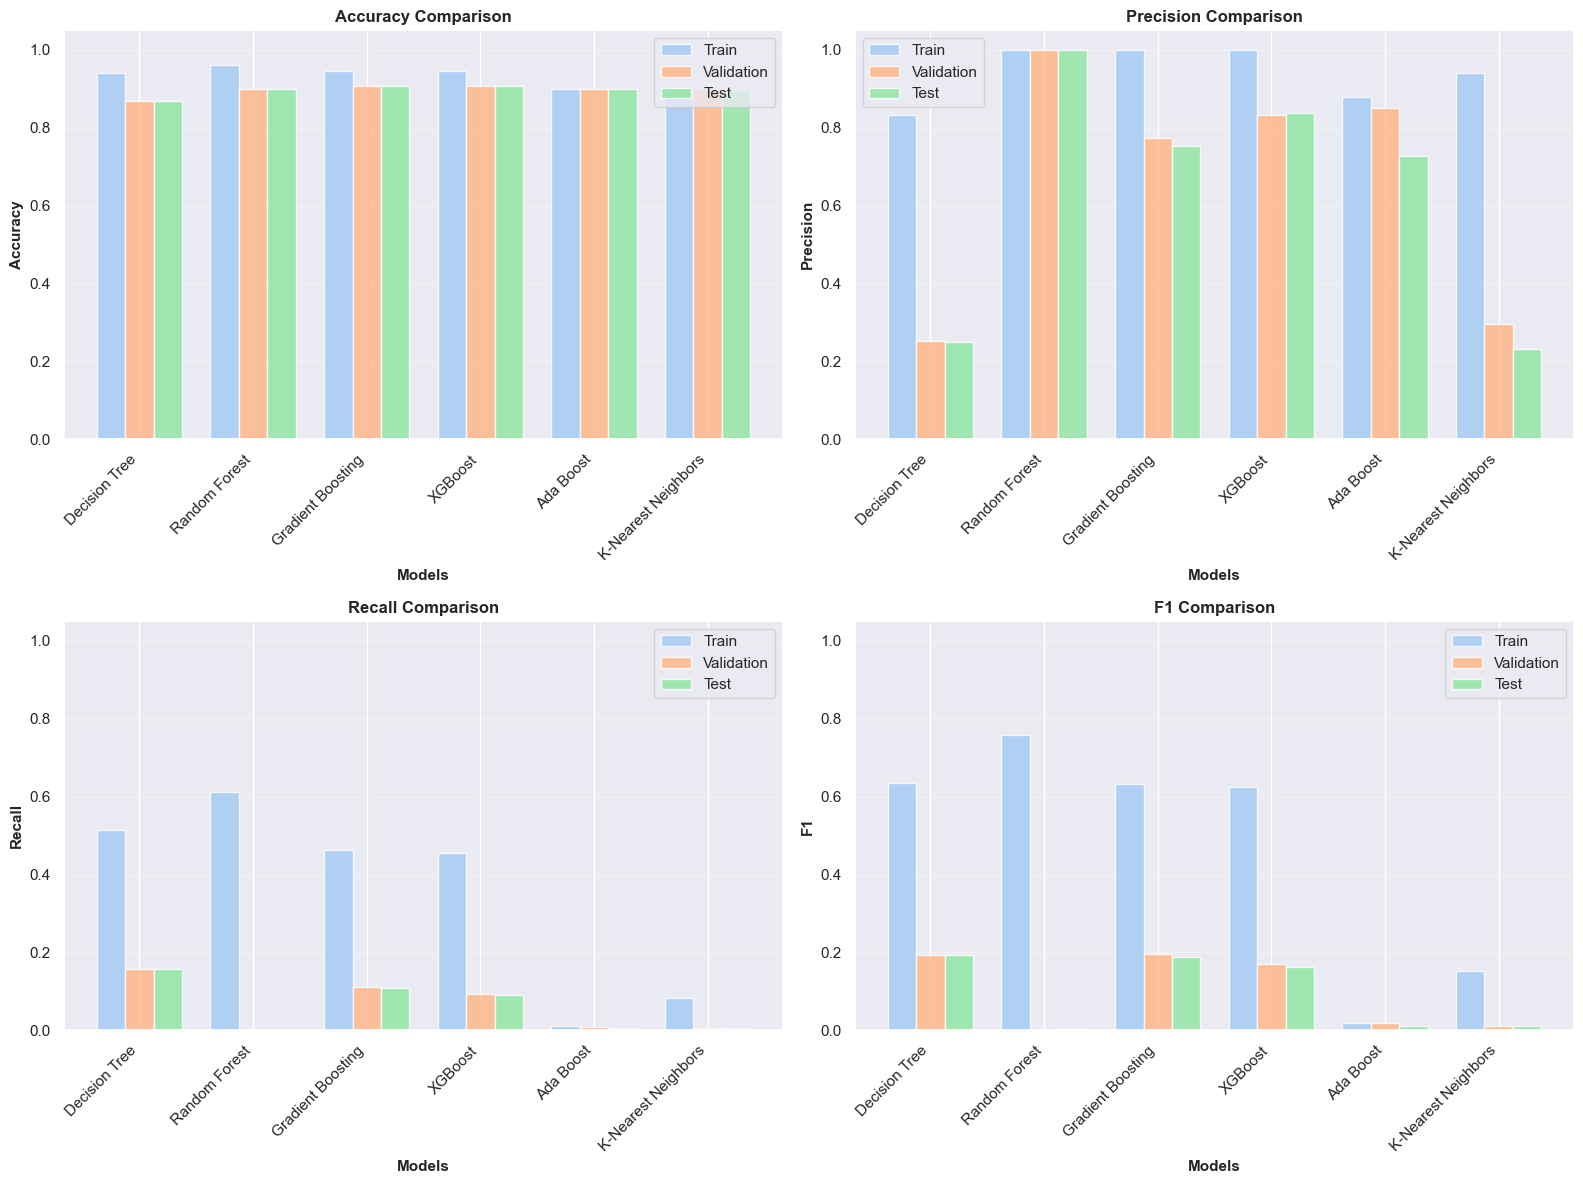

In [22]:
# Visualization - Model Comparison Across Metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    # Extract data for each set
    train_data = [metrics_df.loc[model, f'Train_{metric}'] for model in metrics_df.index]
    val_data = [metrics_df.loc[model, f'Validation_{metric}'] for model in metrics_df.index]
    test_data = [metrics_df.loc[model, f'Test_{metric}'] for model in metrics_df.index]
    
    x = np.arange(len(metrics_df.index))
    width = 0.25
    
    ax.bar(x - width, train_data, width, label='Train', alpha=0.8)
    ax.bar(x, val_data, width, label='Validation', alpha=0.8)
    ax.bar(x + width, test_data, width, label='Test', alpha=0.8)
    
    ax.set_xlabel('Models', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

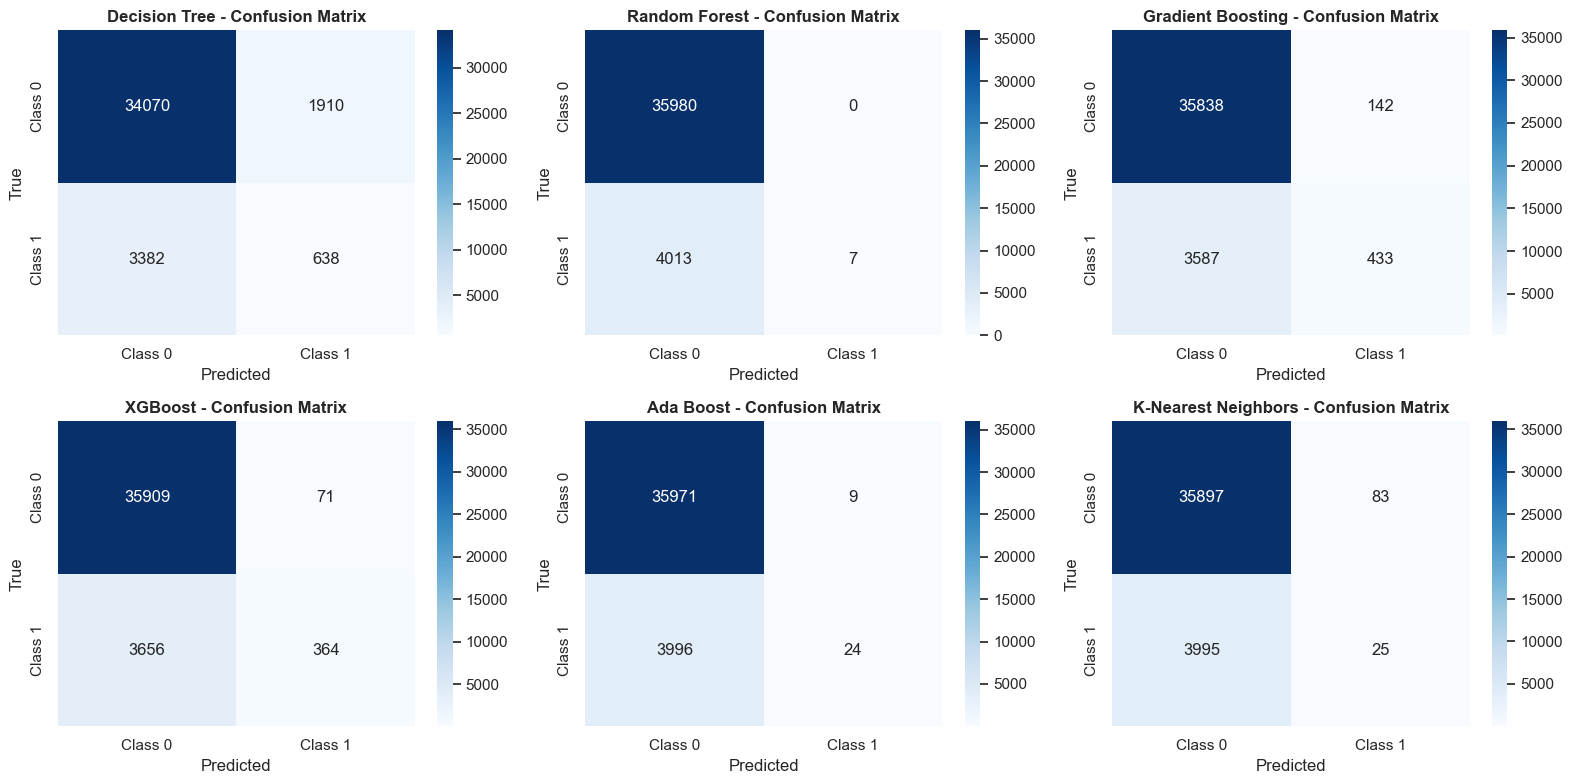

In [23]:
# Detailed Confusion Matrices on Test Set
n_models = len(trained_models)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for idx, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    axes[idx].set_title(f'{name} - Confusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

# Hide extra subplots
for idx in range(n_models, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

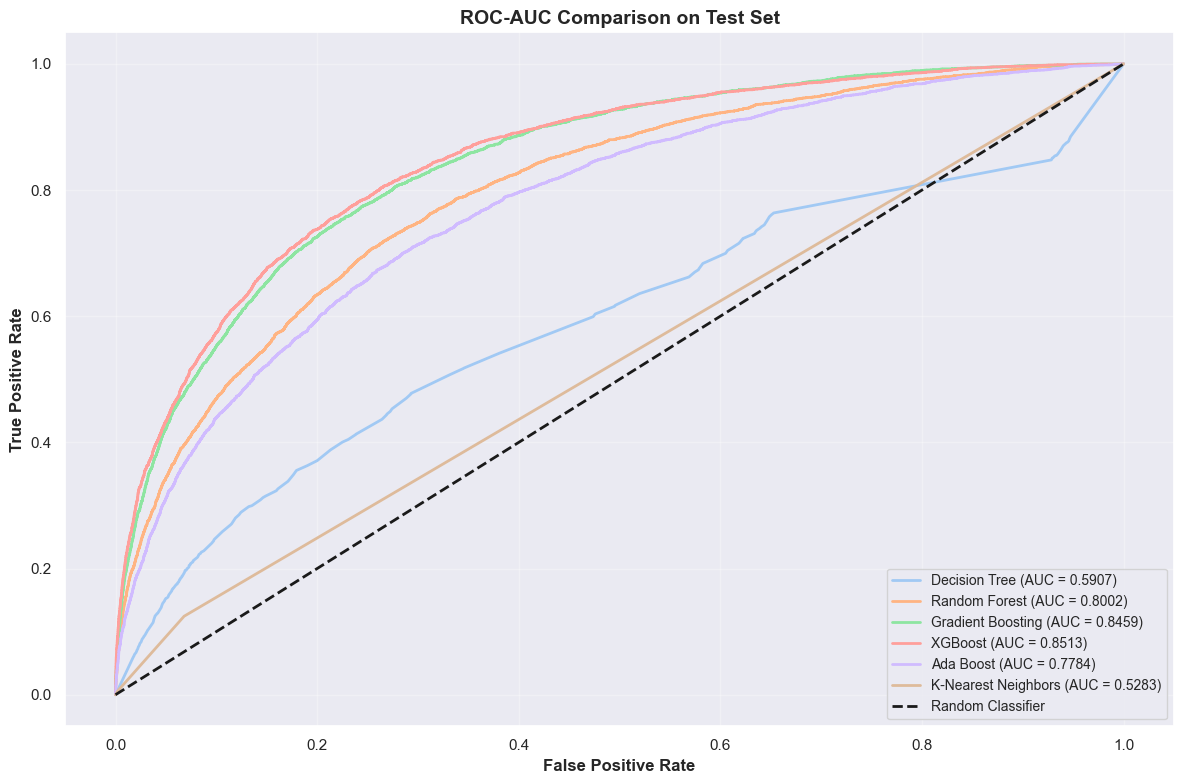

In [24]:
# ROC-AUC Curves Comparison on Test Set
plt.figure(figsize=(12, 8))

for name, model in trained_models.items():
    try:
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.4f})')
    except:
        print(f"Could not compute ROC curve for {name}")

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC-AUC Comparison on Test Set', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
# Model Ranking by Test Performance
ranking = pd.DataFrame()
ranking['Test_Accuracy'] = [metrics_df.loc[model, 'Test_Accuracy'] for model in metrics_df.index]
ranking['Test_F1'] = [metrics_df.loc[model, 'Test_F1'] for model in metrics_df.index]
ranking['Test_AUC'] = [metrics_df.loc[model, 'Test_AUC'] for model in metrics_df.index]
ranking.index = metrics_df.index  # Set index to model names

# Calculate average rank
ranking['Overall_Score'] = (ranking['Test_Accuracy'] + ranking['Test_F1'] + ranking['Test_AUC']) / 3
ranking = ranking.sort_values('Overall_Score', ascending=False)

print("\n" + "=" * 80)
print("MODEL RANKING - SORTED BY TEST PERFORMANCE")
print("=" * 80)
print(ranking.to_string())

print("\n" + "=" * 80)
print(f"BEST MODEL: {ranking.index[0]} with Overall Score: {ranking.iloc[0]['Overall_Score']:.4f}")
print("=" * 80)


MODEL RANKING - SORTED BY TEST PERFORMANCE
                     Test_Accuracy  Test_F1  Test_AUC  Overall_Score
Gradient Boosting           0.9068   0.1885       0.0       0.365100
XGBoost                     0.9068   0.1634       0.0       0.356733
Decision Tree               0.8677   0.1943       0.0       0.354000
Ada Boost                   0.8999   0.0118       0.0       0.303900
K-Nearest Neighbors         0.8980   0.0121       0.0       0.303367
Random Forest               0.8997   0.0035       0.0       0.301067

BEST MODEL: Gradient Boosting with Overall Score: 0.3651


### Model Ranking & Best Model Selection
Rank all models by their overall test performance across multiple metrics and identify the best performing model for further analysis and deployment.

In [26]:
# Get Best Performing Model for SHAP Analysis
best_model_name = ranking.index[0]
best_model = trained_models[best_model_name]

print(f"\nBest Model Selected: {best_model_name}")
print(f"Overall Score: {ranking.iloc[0]['Overall_Score']:.4f}")
print(f"Test Accuracy: {ranking.iloc[0]['Test_Accuracy']:.4f}")
print(f"Test F1 Score: {ranking.iloc[0]['Test_F1']:.4f}")
print(f"Test AUC: {ranking.iloc[0]['Test_AUC']:.4f}")


Best Model Selected: Gradient Boosting
Overall Score: 0.3651
Test Accuracy: 0.9068
Test F1 Score: 0.1885
Test AUC: 0.0000


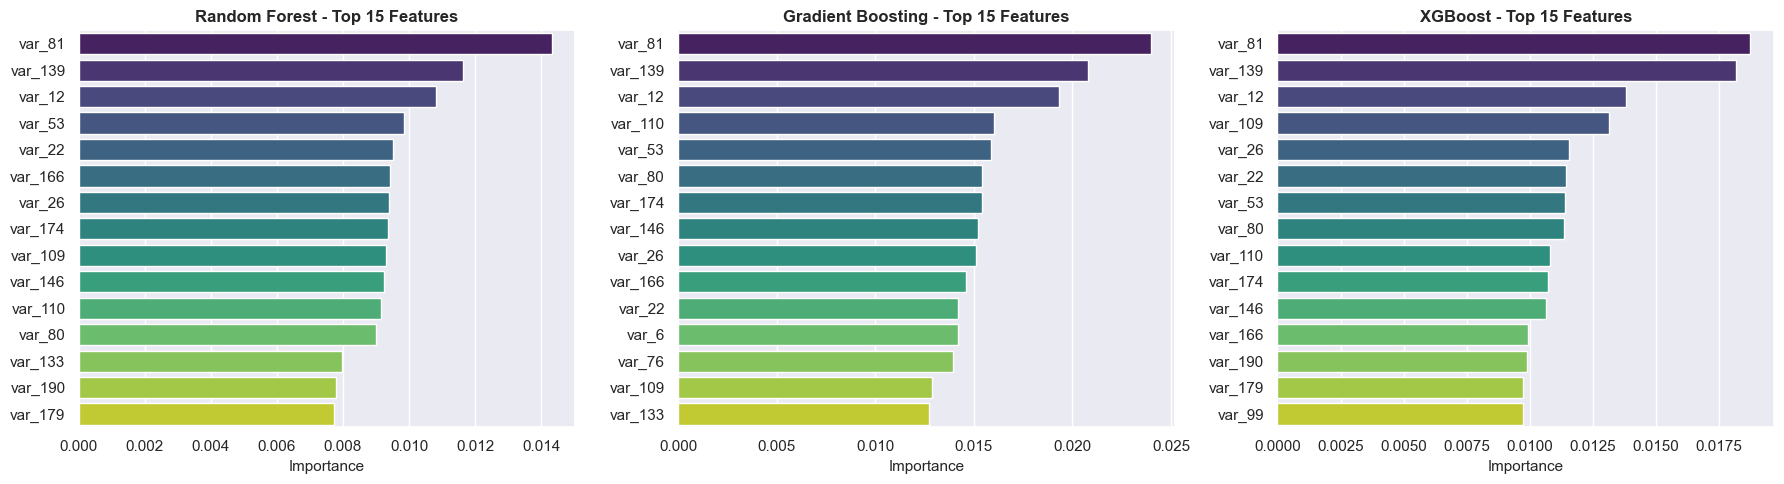

Feature Importance Analysis Completed!


In [27]:
# Feature Importance Analysis from Tree-Based Models
tree_models = {
    'Random Forest': trained_models['Random Forest'],
    'Gradient Boosting': trained_models['Gradient Boosting'],
    'XGBoost': trained_models['XGBoost'],
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(tree_models.items()):
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False).head(15)
    
    sns.barplot(data=importance_df, x='importance', y='feature', ax=axes[idx], palette='viridis')
    axes[idx].set_title(f'{name} - Top 15 Features', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Importance', fontsize=11)
    axes[idx].set_ylabel('')

plt.tight_layout()
plt.show()

print("Feature Importance Analysis Completed!")

### Feature Importance Analysis
Analyze feature importance from tree-based models to understand which features have the most impact on predictions. This helps identify the most influential variables in the dataset.

## SHAP Explainability Analysis - Best Model

In [ ]:
# SHAP Explainer - Initialize for Best Model
print(f"Initializing SHAP Explainer for {best_model_name}...")

# Create SHAP explainer
if hasattr(best_model, 'feature_importances_'):
    # Tree-based model
    explainer = shap.TreeExplainer(best_model)
    print(f"Using TreeExplainer (for tree-based models)")
else:
    # For other models, use KernelExplainer with a smaller sample
    sample_size = min(100, len(X_train_scaled))
    explainer = shap.KernelExplainer(best_model.predict, shap.sample(X_train_scaled, sample_size))
    print(f"Using KernelExplainer with {sample_size} background samples")

# Calculate SHAP values on test set
print(f"\nCalculating SHAP values on test set ({len(X_test_scaled)} samples)...")
shap_values = explainer.shap_values(X_test_scaled)

print("SHAP Explainer initialized successfully!")

Initializing SHAP Explainer for Gradient Boosting...
Using TreeExplainer (for tree-based models)

Calculating SHAP values on test set (40000 samples)...
SHAP Explainer initialized successfully!



Generating SHAP Summary Plot for Gradient Boosting...


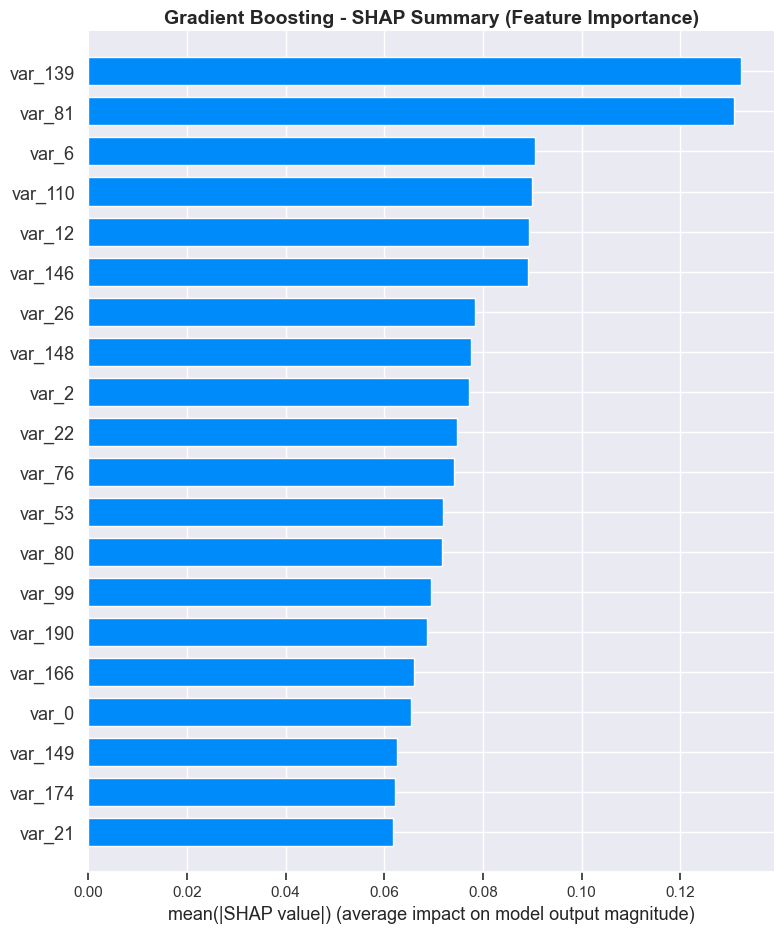

SHAP Summary Plot completed!


In [29]:
# SHAP Summary Plot - Feature Importance
print(f"\nGenerating SHAP Summary Plot for {best_model_name}...")

# For binary classification, shap_values might be a list
if isinstance(shap_values, list):
    # Use positive class (class 1) SHAP values
    sv = shap_values[1]
else:
    sv = shap_values

plt.figure(figsize=(12, 8))
shap.summary_plot(sv, X_test_scaled, plot_type="bar", show=False)
plt.title(f"{best_model_name} - SHAP Summary (Feature Importance)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("SHAP Summary Plot completed!")


Generating SHAP Dependence Plots for Gradient Boosting...


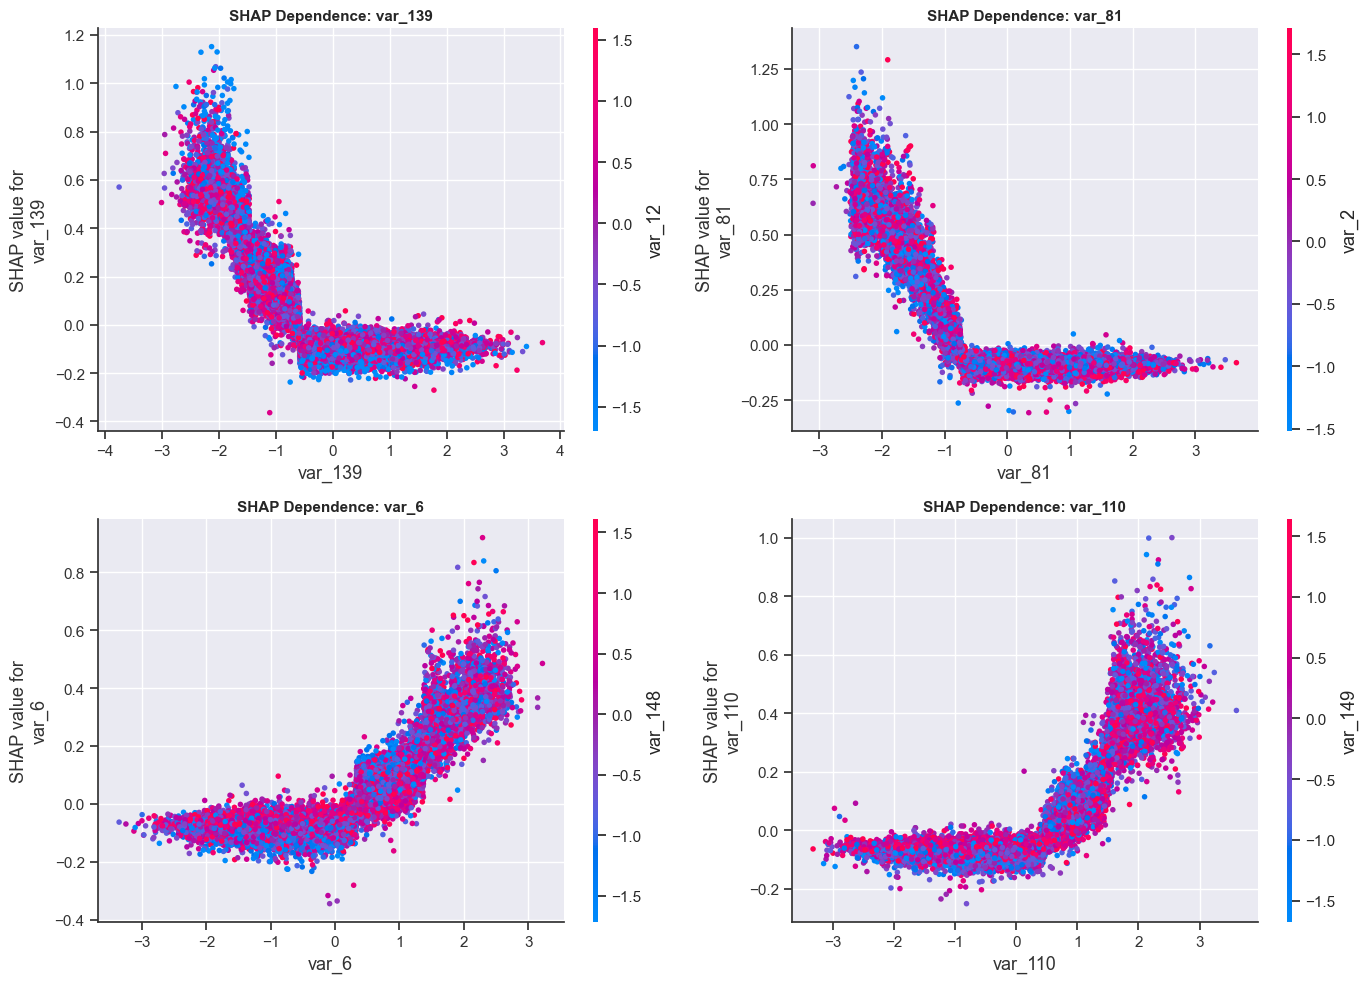

SHAP Dependence Plots completed!


In [30]:
# SHAP Dependence Plot - Top Features Interaction
print(f"\nGenerating SHAP Dependence Plots for {best_model_name}...")

# Get top features by mean absolute SHAP value
feature_importance = np.abs(sv).mean(axis=0)
top_feature_indices = np.argsort(feature_importance)[-4:][::-1]  # Top 4 features

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature_idx in enumerate(top_feature_indices):
    ax = axes[idx]
    feature_name = X_test_scaled.columns[feature_idx]
    
    shap.dependence_plot(feature_idx, sv, X_test_scaled, ax=ax, show=False)
    ax.set_title(f"SHAP Dependence: {feature_name}", fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("SHAP Dependence Plots completed!")

In [31]:
# SHAP Force Plot - Individual Predictions
print(f"\nGenerating SHAP Force Plots for sample predictions ({best_model_name})...")

# Display force plot for a few sample predictions
sample_indices = [0, 50, 100, 150]  # Different samples

for sample_idx in sample_indices:
    prediction = best_model.predict(X_test_scaled.iloc[[sample_idx]])[0]
    
    # Get probability if available
    try:
        probability = best_model.predict_proba(X_test_scaled.iloc[[sample_idx]])[0]
        prob_text = f"Probability: Class 0={probability[0]:.4f}, Class 1={probability[1]:.4f}"
    except:
        prob_text = ""
    
    print(f"\nSample {sample_idx}:")
    print(f"  Actual: {y_test.iloc[sample_idx]}, Predicted: {prediction} {prob_text}")
    
    # SHAP force plot
    if isinstance(shap_values, list):
        sv_sample = shap_values[1][sample_idx]
    else:
        sv_sample = shap_values[sample_idx]
    
    try:
        shap.force_plot(explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1], 
                       sv_sample, X_test_scaled.iloc[sample_idx], show=False)
    except:
        print("  (Force plot visualization not available in notebook context)")

print("\nSHAP Force Plots completed!")


Generating SHAP Force Plots for sample predictions (Gradient Boosting)...

Sample 0:
  Actual: 0, Predicted: 0 Probability: Class 0=0.9533, Class 1=0.0467

Sample 50:
  Actual: 0, Predicted: 0 Probability: Class 0=0.9715, Class 1=0.0285

Sample 100:
  Actual: 1, Predicted: 0 Probability: Class 0=0.8925, Class 1=0.1075

Sample 150:
  Actual: 1, Predicted: 0 Probability: Class 0=0.6134, Class 1=0.3866

SHAP Force Plots completed!



Generating SHAP Waterfall Plots for sample predictions (Gradient Boosting)...


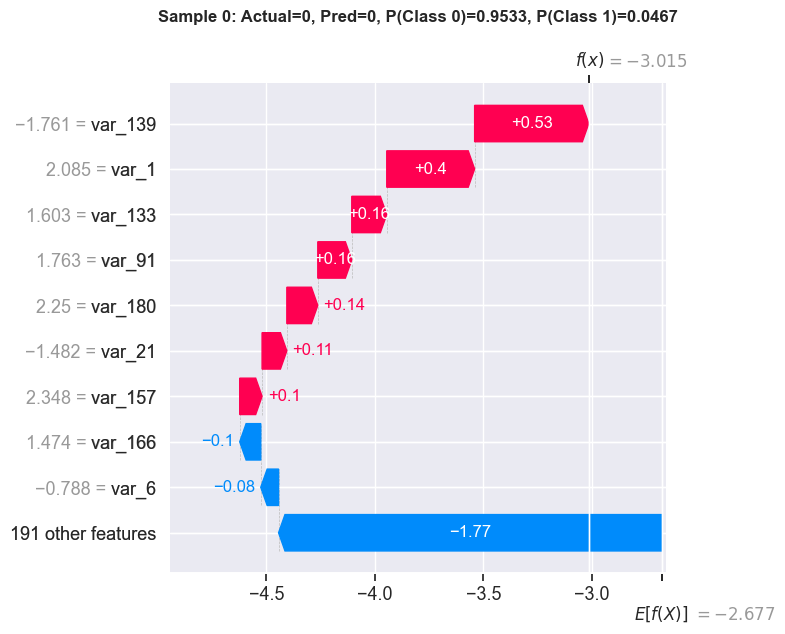

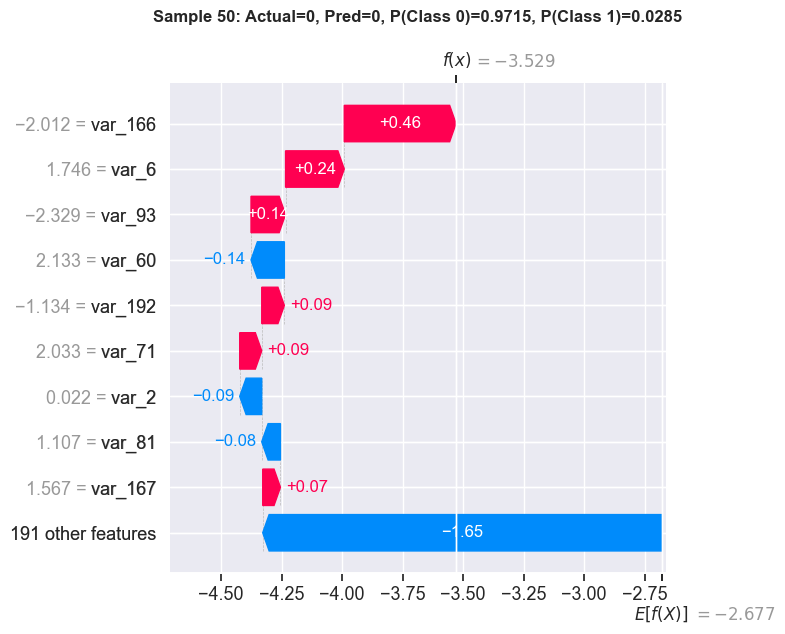

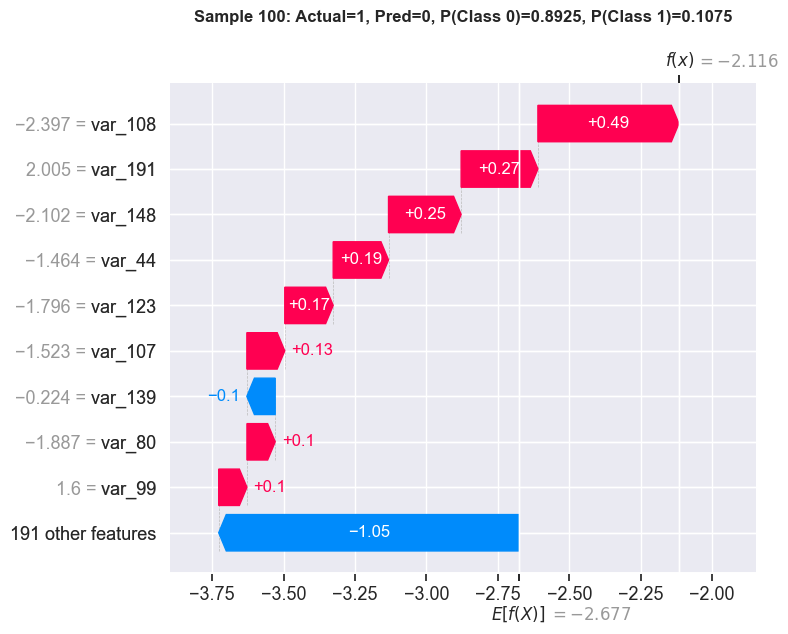

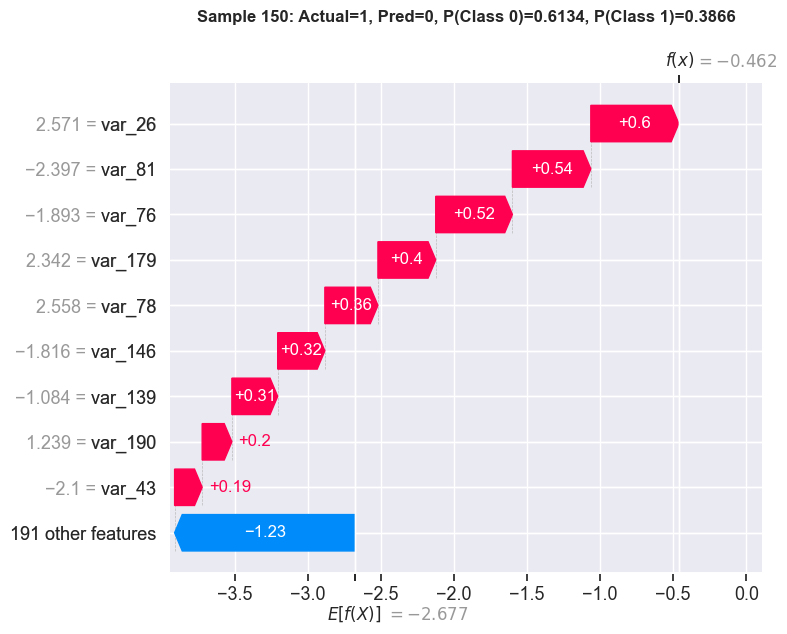

SHAP Waterfall Plots completed!


In [33]:
# SHAP Waterfall Plot - Individual Prediction Decision
print(f"\nGenerating SHAP Waterfall Plots for sample predictions ({best_model_name})...")

# Display waterfall plot for the same sample predictions
sample_indices = [0, 50, 100, 150]  # Same samples as force plots

for sample_idx in sample_indices:
    # Get prediction and probability
    prediction = best_model.predict(X_test_scaled.iloc[[sample_idx]])[0]
    
    try:
        probability = best_model.predict_proba(X_test_scaled.iloc[[sample_idx]])[0]
        prob_text = f"P(Class 0)={probability[0]:.4f}, P(Class 1)={probability[1]:.4f}"
    except:
        prob_text = f"Predicted: {prediction}"
    
    # Get SHAP values for this sample
    if isinstance(shap_values, list):
        sv_sample = shap_values[1][sample_idx]
    else:
        sv_sample = shap_values[sample_idx]
    
    # Create separate waterfall plot for each sample
    plt.figure(figsize=(14, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=sv_sample,
            base_values=explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1],
            data=X_test_scaled.iloc[sample_idx].values,
            feature_names=X_test_scaled.columns.tolist()
        ),
        show=False
    )
    plt.title(f"Sample {sample_idx}: Actual={y_test.iloc[sample_idx]}, Pred={prediction}, {prob_text}", 
              fontsize=12, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

print("SHAP Waterfall Plots completed!")